In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
def one_tree_gc(X, y, depth=3):
    dt = DecisionTreeClassifier()
    
    params = {'criterion': ['gini', 'entropy'],
         'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
         'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    
    cv = TimeSeriesSplit(n_splits=8)
    gs = GridSearchCV(dt, params, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    gs.fit(X, y)
    
    score = gs.best_score_
    dt = gs.best_estimator_
    dt.fit(X, y)
    print(dt)
    print(X.columns[np.argsort(dt.feature_importances_)])
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data, max_depth=depth, feature_names=X.columns,
    filled=True, rounded=True,
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png())
    return score, img
    
    

In [32]:
train = pd.read_csv('EXPRESS_COURSES_0.csv',error_bad_lines=False,parse_dates=[0])
train.dropna(inplace=True)

In [33]:
train.head()

,receivd,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,aimi,uvozr,ulevel,target
0,2018-01-30 19:02:41,0,0,2,1200,0,0,50,1,40,60,0,0
1,2016-12-06 10:55:36,2,-1,1,600,0,0,0,2,30,40,30,0
2,2018-03-18 11:19:46,0,0,2,1500,0,0,0,2,30,30,0,0
3,2016-03-25 12:56:26,0,1,2,1500,0,20,55,2,-20,10,20,0
4,2017-05-27 07:25:27,2,0,1,1000,0,15,55,3,30,60,30,1


In [34]:
data = train
data['receivd'] = pd.to_datetime(data['receivd'])
data.sort_values(['receivd'], inplace=True)


In [35]:
data = data.drop(columns='razvned')

In [36]:
data['month'] = data['receivd'].map(lambda x: x.month)
data['hour'] = data['receivd'].map(lambda x: x.hour)
data['weekday'] = data['receivd'].map(lambda x: x.dayofweek)
data['day'] = data['receivd'].map(lambda x: x.day)
data['year'] = data['receivd'].map(lambda x: x.year)

In [37]:
data.head()

,receivd,city,mesto,prodolzh,stoim,wgender,obraz,opyt,aimi,uvozr,ulevel,target,month,hour,weekday,day,year
190976,2013-01-01 01:17:54,1,1,2,600,-2,20,55,30,30,20,0,1,1,1,1,2013
192645,2013-01-01 07:50:02,2,1,2,400,-2,20,55,30,20,20,1,1,7,1,1,2013
71696,2013-01-01 09:40:31,0,-1,1,1500,0,20,0,30,40,30,0,1,9,1,1,2013
134823,2013-01-01 10:30:48,2,1,2,300,0,0,0,30,20,20,0,1,10,1,1,2013
254441,2013-01-01 13:09:45,2,1,2,350,0,20,55,-10,70,10,0,1,13,1,1,2013


In [10]:
data = data[data['obraz'] != 35]

In [38]:
data_sparse = pd.get_dummies(data, columns=['mesto','wgender','obraz','opyt','prodolzh','aimi','uvozr','ulevel','month','weekday','city', 'hour','day','year'])

In [39]:
tree_data = data.drop(columns=['receivd'])


In [40]:
tree_data.head(1)

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,aimi,uvozr,ulevel,target,month,hour,weekday,day,year
190976,1,1,2,600,-2,20,55,30,30,20,0,1,1,1,1,2013


In [41]:
scaler = StandardScaler()
num_cols_scale = scaler.fit_transform(data['stoim'].values.reshape(-1,1))
data_sparse['stoim'] = num_cols_scale
data_sparse= data_sparse.reset_index(drop=True)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
data_sparse.head(1)

,receivd,stoim,target,mesto_-1,mesto_0,mesto_1,mesto_3,wgender_-2,wgender_0,wgender_2,...,day_28,day_29,day_30,day_31,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,2013-01-01 01:17:54,-0.040128,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
log_data = data_sparse.drop(columns = ['receivd'])

In [44]:
school = data[data['uvozr'].isin([35,40])].groupby(['year','month'])

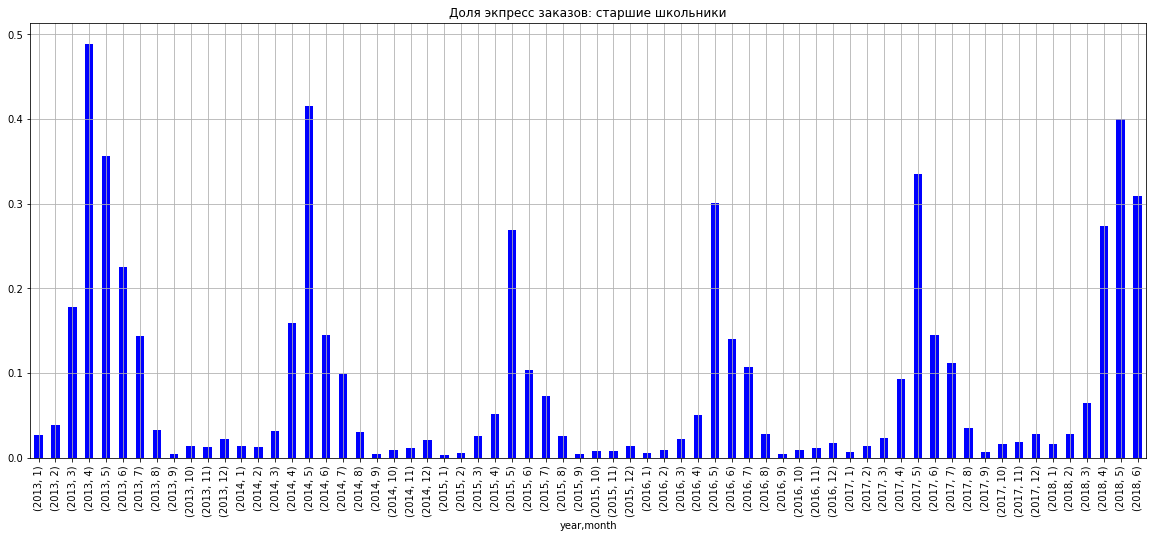

In [45]:
school = data[data['uvozr'].isin([35,40])].groupby(['year','month'])
grp = school['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: старшие школьники')

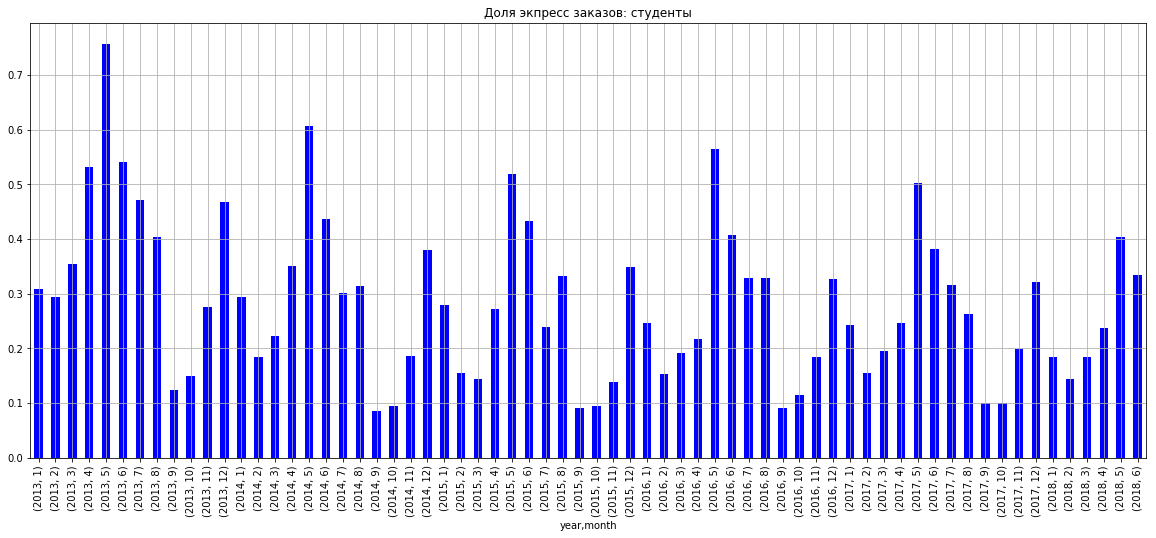

In [46]:
univer = data[data['uvozr'].isin([50,60])].groupby(['year','month'])
grp = univer['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: студенты')

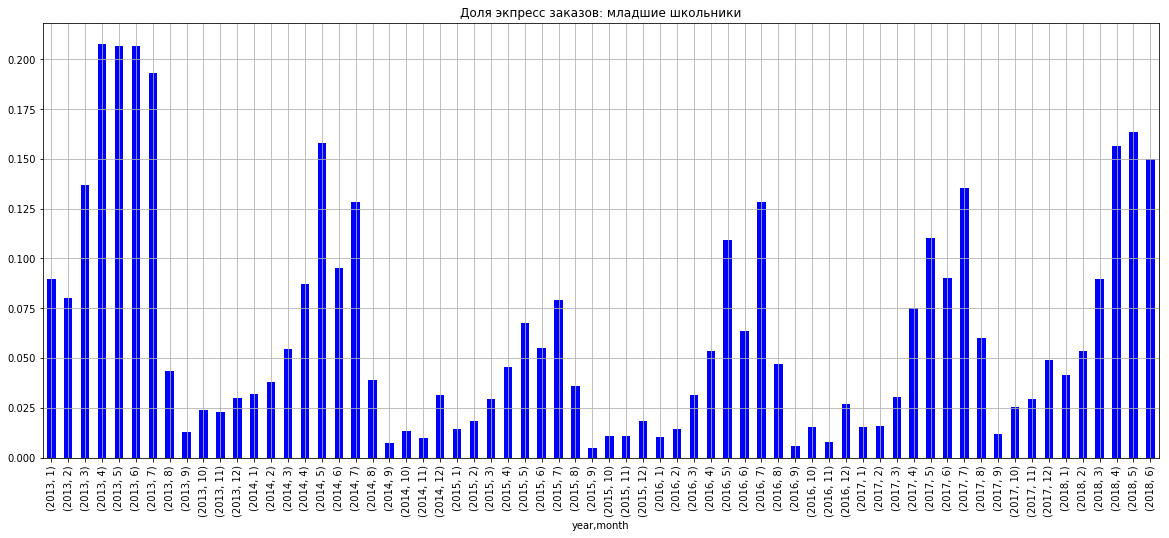

In [47]:
univer = data[data['uvozr'].isin([10,20,25,30])].groupby(['year','month'])
grp = univer['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: младшие школьники')

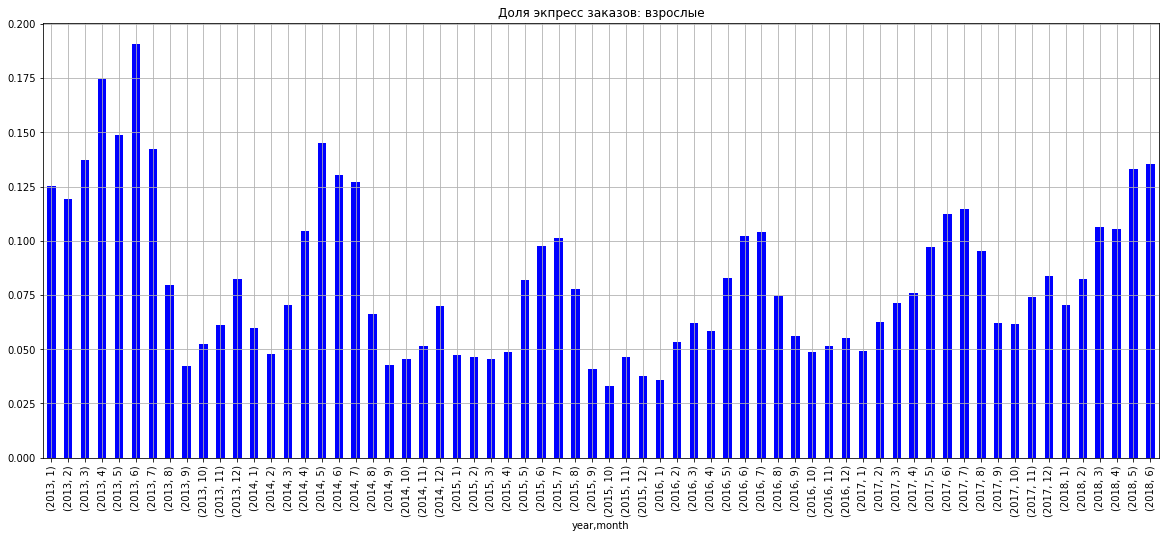

In [48]:
univer = data[data['uvozr'].isin([70,80,90])].groupby(['year','month'])
grp = univer['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: взрослые')

In [49]:
def randomforest(X,y,n_est, tpr_val, graph = True, max_features = 1):
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=False)
    
    fr = RandomForestClassifier(n_estimators=n_est, n_jobs=-1, max_features=max_features)
    
    cv = TimeSeriesSplit(n_splits = 8)
    
    cross_score = cross_val_score(fr, X_train, y_train, scoring ='roc_auc', cv=cv, n_jobs=-1)
    
    fr.fit(X_train, y_train)
    score = roc_auc_score(y_test, fr.predict_proba(X_test)[:,1])
    fpr, tpr, tresh = roc_curve(y_test, fr.predict_proba(X_test)[:,1] )
    
    if graph:
        fpr, tpr, tresh = roc_curve(y_test, fr.predict_proba(X_test)[:,1] )
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % score)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC AUC')
        plt.axis('square')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show() 
    
        cm = confusion_matrix(y_test, (fr.predict_proba(X_test)[:,1] > tresh[tpr > tpr_val][0]).astype(int) )
    
        plot_confusion_matrix(cm,[0,1])
    
    return cross_score, score, y_test, fr.predict_proba(X_test)[:,1]
    
    

# Модели

# Лес без весны

In [50]:
tree_data_no_spr = tree_data[~tree_data['month'].isin((4,5,6))]
tree_data_no_spr = tree_data_no_spr[tree_data_no_spr['year'] != 2018]
tree_data_no_spr = tree_data_no_spr[~((tree_data_no_spr['year'] == 2017) & (tree_data_no_spr['month'] > 8))]
tree_data_no_spr = pd.get_dummies(tree_data_no_spr, columns=['month','aimi','prodolzh'])


In [51]:
tree_data_no_spr.head(1)

,city,mesto,stoim,wgender,obraz,opyt,uvozr,ulevel,target,hour,...,aimi_10,aimi_20,aimi_30,aimi_40,prodolzh_-2,prodolzh_-1,prodolzh_0,prodolzh_1,prodolzh_2,prodolzh_3
190976,1,1,600,-2,20,55,30,20,0,1,...,0,0,1,0,0,0,0,0,1,0


In [52]:
X_tree = tree_data_no_spr.drop(columns=['target','year'])
y_tree = tree_data_no_spr['target']

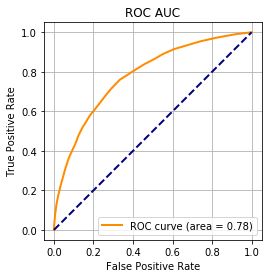

Confusion matrix, without normalization
[[46300 10965]
 [ 1234  1788]]
[0.8092436  0.77560774 0.81739822 0.7787407  0.76579314 0.82025267
 0.79318461 0.78178012] 0.7796736271388669


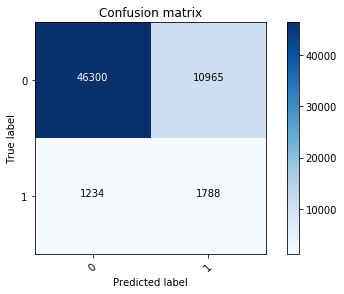

In [53]:
scores, score, true, pred = randomforest(X_tree, y_tree, tpr_val=0.6, n_est=250)
print(scores, score)

Confusion matrix, without normalization
[[41859 15406]
 [  937  2085]]


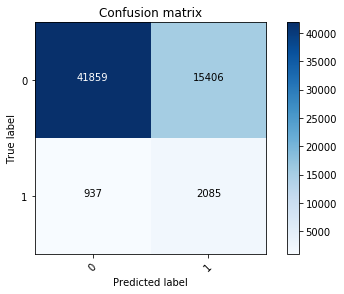

In [54]:
fpr, tpr, tresh = roc_curve(true, pred )
cm = confusion_matrix(true, (pred > tresh[tpr > 0.7][0]).astype(int) )
plot_confusion_matrix(cm,[0,1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Index(['month_11', 'prodolzh_2', 'obraz', 'aimi_10', 'month_2', 'prodolzh_-2',
       'aimi_-20', 'aimi_0', 'prodolzh_1', 'weekday', 'prodolzh_-1', 'aimi_30',
       'hour', 'mesto', 'opyt', 'prodolzh_3', 'aimi_-10', 'wgender',
       'prodolzh_0', 'city', 'month_1', 'stoim', 'month_3', 'month_10',
       'month_9', 'aimi_-30', 'month_12', 'aimi_20', 'month_8', 'ulevel',
       'day', 'aimi_40', 'month_7', 'uvozr'],
      dtype='object')
0.7896214120990107


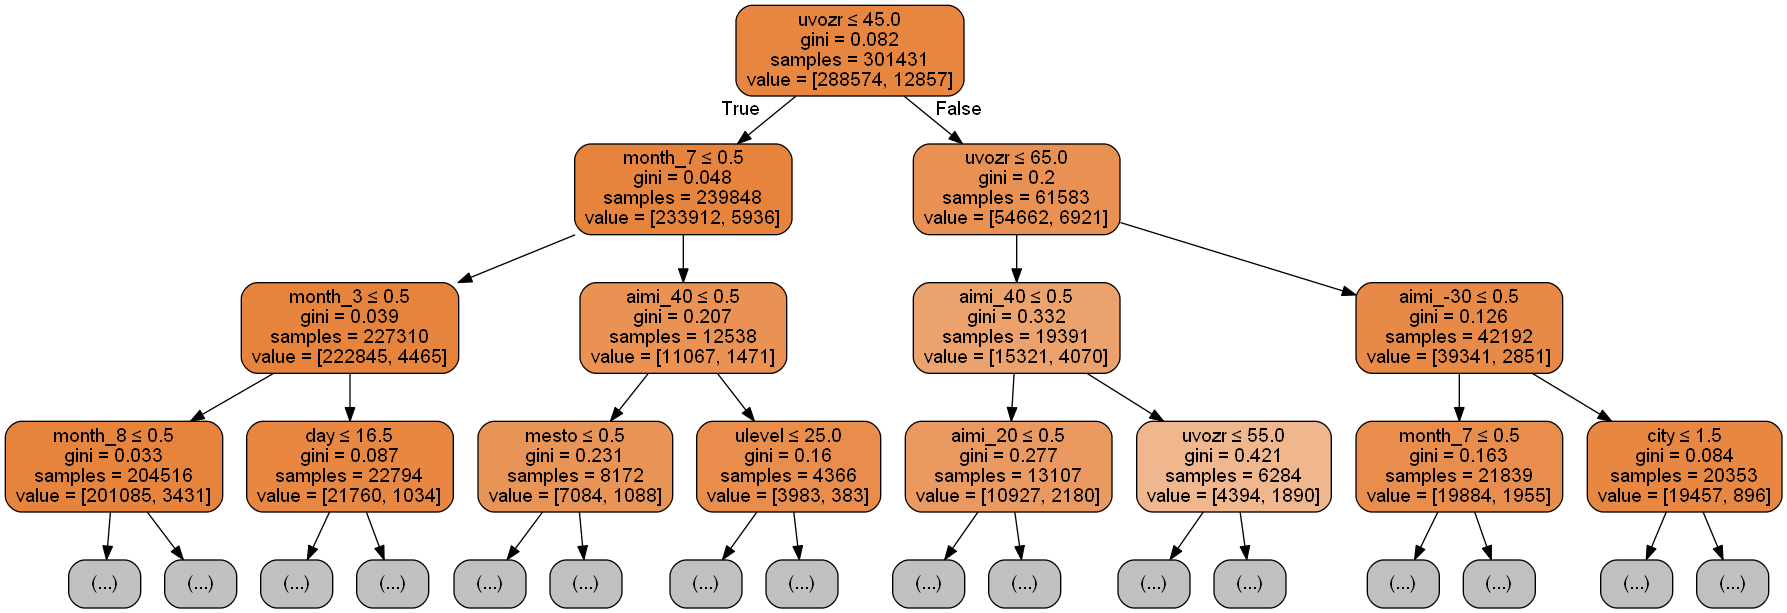

In [55]:
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

# Лес весна

In [56]:
tree_data_spr = tree_data[tree_data['month'].isin((4,5,6))]
tree_data_spr = tree_data_spr[tree_data_spr['year'] != 2018]
tree_data_spr = pd.get_dummies(tree_data_spr, columns=['month','aimi'])


In [57]:
X_tree = tree_data_spr.drop(columns=['target','year'])
y_tree = tree_data_spr['target']

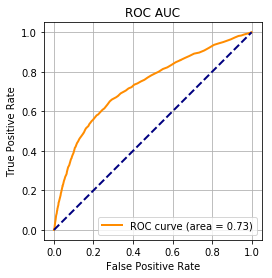

Confusion matrix, without normalization
[[7373 2300]
 [ 828 1242]]
[0.61915664 0.74519844 0.7528284  0.74665159 0.66759095 0.76203633
 0.68413167 0.65608251] 0.7298539287852885


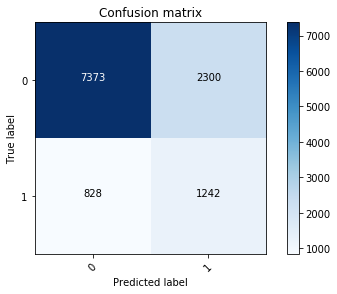

In [58]:
scores, score, true, pred = randomforest(X_tree, y_tree, 250, 0.6)
print(scores, score)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Index(['aimi_0', 'mesto', 'aimi_30', 'weekday', 'aimi_10', 'aimi_-20',
       'wgender', 'aimi_-10', 'obraz', 'aimi_20', 'hour', 'opyt', 'month_6',
       'city', 'aimi_-30', 'prodolzh', 'stoim', 'month_4', 'ulevel', 'day',
       'month_5', 'aimi_40', 'uvozr'],
      dtype='object')
0.6954584637223123


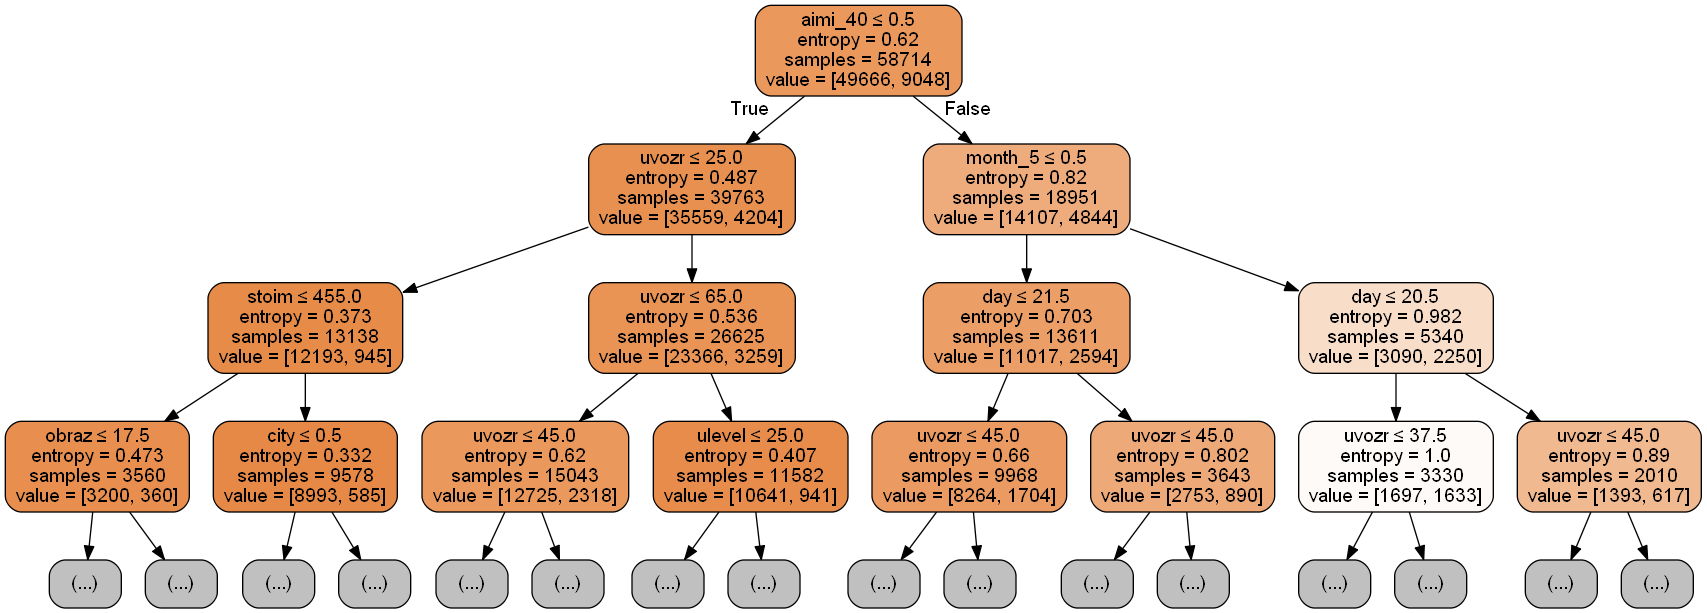

In [59]:
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

# Старшеклассники

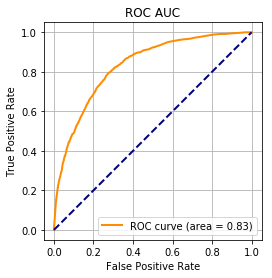

Confusion matrix, without normalization
[[23822  4160]
 [  717  1061]]
[0.58516973 0.83327397 0.67228305 0.79504293 0.66446409 0.76673265
 0.8731235  0.68098188] 0.8311336393418265


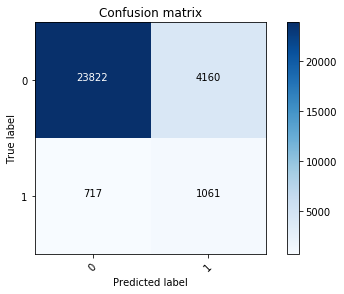

In [61]:
tree_11 = tree_data[tree_data['uvozr'].isin([35,40])]
tree_11 = tree_11[tree_11['year'] != 2018]
tree_11 = tree_11[~((tree_11['year'] == 2017) & (tree_11['month'] > 8))]
tree_11 = pd.get_dummies(tree_11, columns=['month','aimi'])


X_tree = tree_11.drop(columns=['target','year'])
y_tree = tree_11['target']

scores, score, true_11, pred_11 = randomforest(X_tree, y_tree, 1000,0.6)
print(scores, score)

Confusion matrix, without normalization
[[20059  7923]
 [  358  1420]]


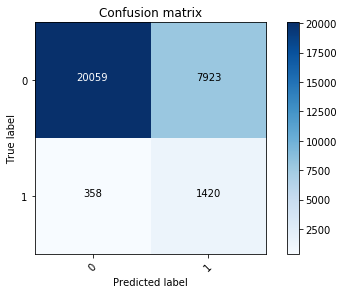

In [62]:
fpr, tpr, tresh = roc_curve(true_11, pred_11 )
cm = confusion_matrix(true_11, (pred_11 > tresh[tpr > 0.8][0]).astype(int) )
plot_confusion_matrix(cm,[0,1])

In [63]:
%%time
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=0.7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Index(['month_1', 'month_12', 'month_11', 'month_10', 'aimi_-10', 'month_2',
       'aimi_-20', 'aimi_10', 'aimi_-30', 'aimi_0', 'wgender', 'aimi_20',
       'obraz', 'mesto', 'city', 'aimi_30', 'opyt', 'weekday', 'uvozr', 'hour',
       'month_8', 'ulevel', 'prodolzh', 'stoim', 'month_9', 'month_3',
       'aimi_40', 'day', 'month_7', 'month_6', 'month_4', 'month_5'],
      dtype='object')
0.7513753713289841
Wall time: 1min 50s


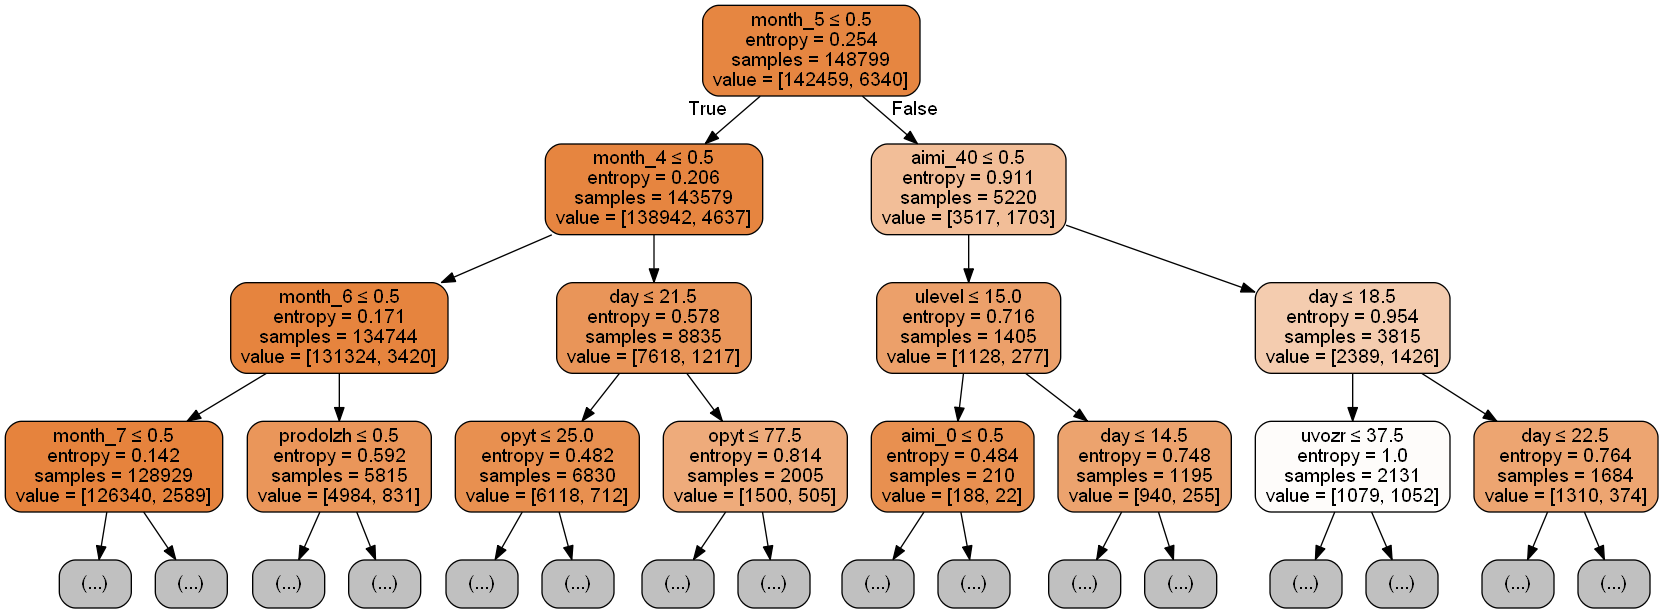

In [64]:
img

# Студенты

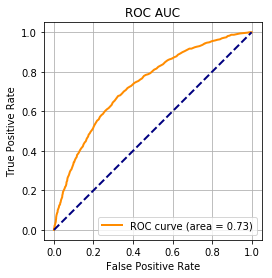

Confusion matrix, without normalization
[[2552  867]
 [ 542  797]]
[0.71141807 0.72381252 0.70555127 0.74635652 0.72697085 0.71852052
 0.75613448 0.65620512] 0.7314848206907715


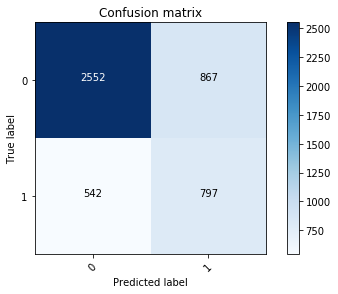

In [65]:
tree_st = tree_data[tree_data['uvozr'].isin([50,60])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
tree_st = pd.get_dummies(tree_st, columns=['month','aimi'])


X_tree = tree_st.drop(columns=['target','year'])
y_tree = tree_st['target']

scores, score,true_st, pred_st = randomforest(X_tree, y_tree, 250,0.6)
print(scores, score)

Confusion matrix, without normalization
[[1752 1667]
 [ 277 1062]]


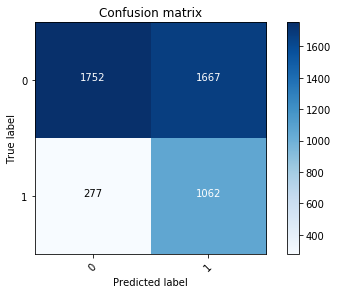

In [66]:
fpr, tpr, tresh = roc_curve(true_st, pred_st )
cm = confusion_matrix(true_st, (pred_st > tresh[tpr > 0.8][0]).astype(int) )
plot_confusion_matrix(cm,[0,1])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Index(['month_4', 'month_12', 'month_11', 'month_1', 'month_2', 'aimi_-20',
       'aimi_0', 'aimi_-10', 'aimi_10', 'aimi_30', 'month_8', 'month_3',
       'mesto', 'opyt', 'obraz', 'city', 'weekday', 'prodolzh', 'hour',
       'stoim', 'month_7', 'aimi_-30', 'wgender', 'day', 'month_6', 'aimi_20',
       'month_10', 'ulevel', 'month_9', 'uvozr', 'aimi_40', 'month_5'],
      dtype='object')
0.6973467585245589


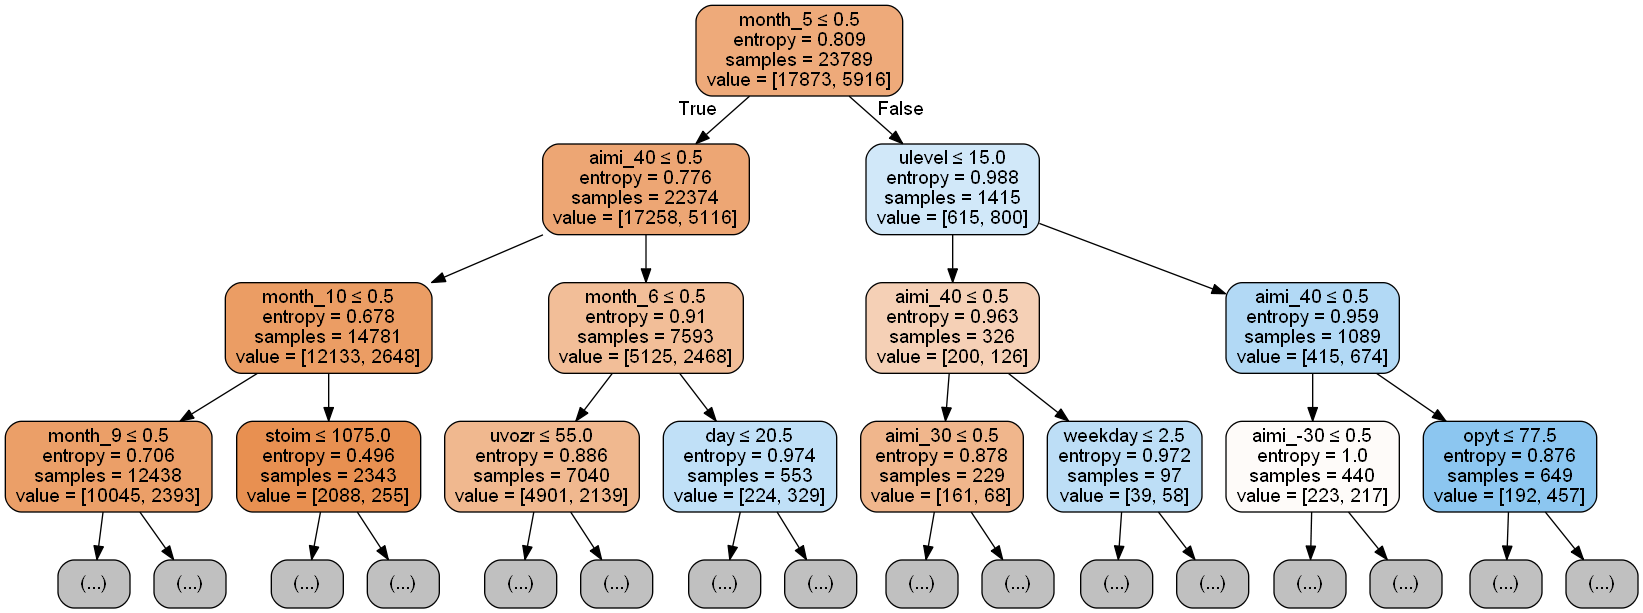

In [67]:
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

# Школозавры


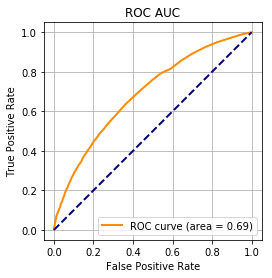

Confusion matrix, without normalization
[[17220  7857]
 [  585   811]]
[0.70233363 0.75025283 0.63824091 0.68296932 0.55680481 0.66540142
 0.75963367 0.58652104] 0.6893358713043483


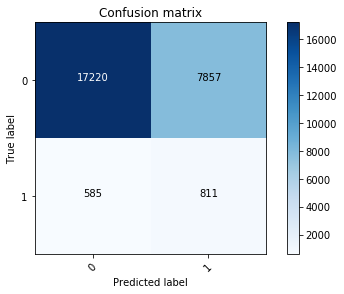

In [68]:
tree_7 = tree_data[tree_data['uvozr'].isin([10,20,25,30])]
tree_7 = tree_7[tree_7['year'] != 2018]
tree_7 = tree_7[~((tree_7['year'] == 2017) & (tree_7['month'] > 8))]
tree_7 = pd.get_dummies(tree_7, columns=['month','aimi'])

X_tree = tree_7.drop(columns=['target','year'])
y_tree = tree_7['target']

scores, score, true_7, pred_7 = randomforest(X_tree, y_tree, 250,0.6)
print(scores, score)

Confusion matrix, without normalization
[[11485 13592]
 [  289  1107]]


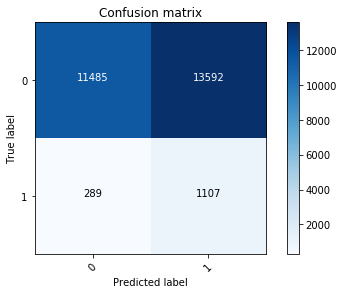

In [69]:
fpr, tpr, tresh = roc_curve(true_7, pred_7 )
cm = confusion_matrix(true_7, (pred_7 > tresh[tpr > 0.8][0]).astype(int) )
plot_confusion_matrix(cm,[0,1])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Index(['month_1', 'month_11', 'month_10', 'aimi_-10', 'aimi_0', 'month_2',
       'month_12', 'aimi_-20', 'aimi_10', 'aimi_-30', 'wgender', 'aimi_20',
       'mesto', 'opyt', 'month_3', 'obraz', 'month_8', 'weekday', 'hour',
       'uvozr', 'ulevel', 'prodolzh', 'city', 'day', 'aimi_30', 'month_4',
       'stoim', 'month_6', 'month_5', 'aimi_40', 'month_7', 'month_9'],
      dtype='object')
0.6515743560513282


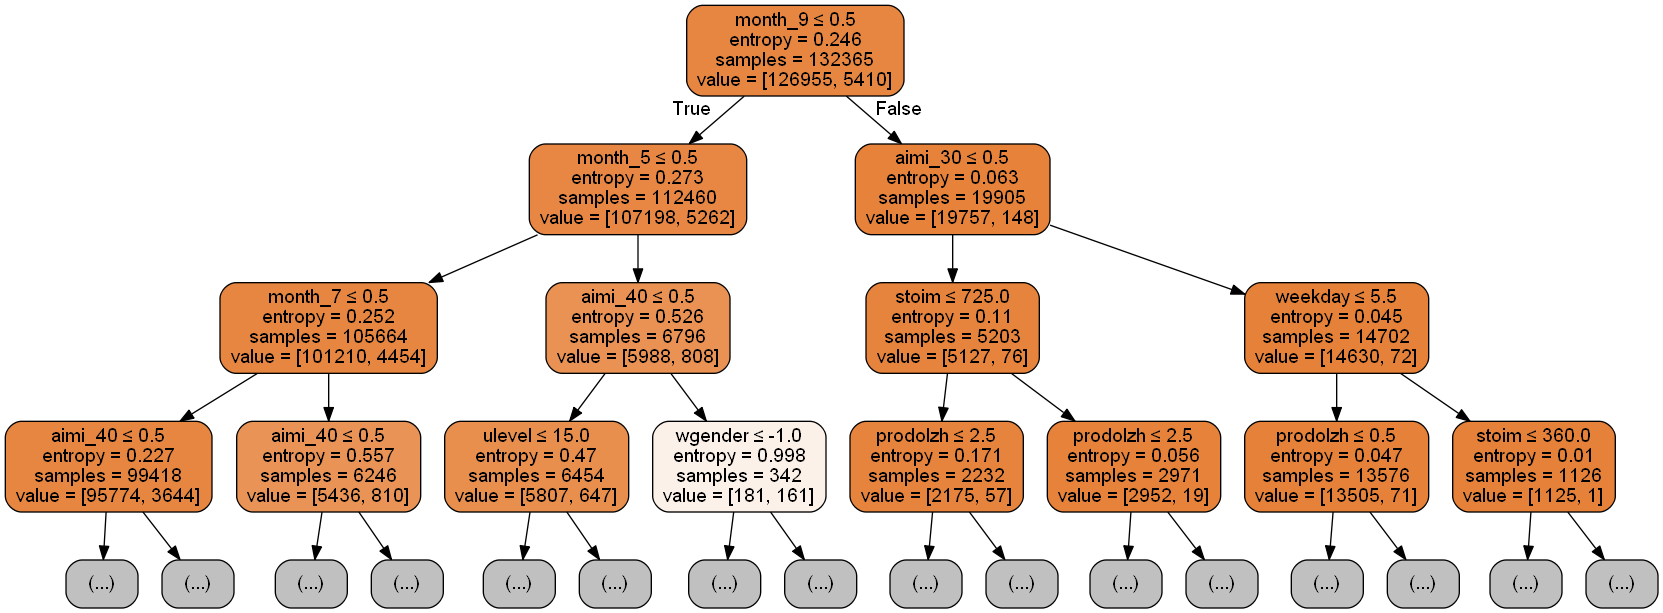

In [70]:
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

# Взрослые

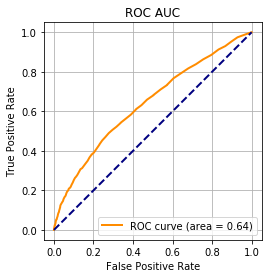

Confusion matrix, without normalization
[[6166 3932]
 [ 392  549]]
[0.66705743 0.62827541 0.73110095 0.6546986  0.70449668 0.63281362
 0.66491672 0.62075913] 0.6393326800121824


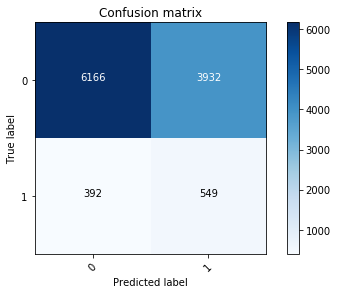

In [72]:
tree_ad = tree_data[tree_data['uvozr'].isin([70,80,90])]
tree_ad = tree_ad[tree_ad['year'] != 2018]
tree_ad = tree_ad[~((tree_ad['year'] == 2017) & (tree_ad['month'] > 8))]
tree_ad = pd.get_dummies(tree_ad, columns=['month','aimi'])

X_tree = tree_ad.drop(columns=['target','year'])
y_tree = tree_ad['target']

scores, score, true_vz, pred_vz = randomforest(X_tree, y_tree, 250,0.6)
print(scores, score)

Confusion matrix, without normalization
[[3612 6486]
 [ 196  745]]


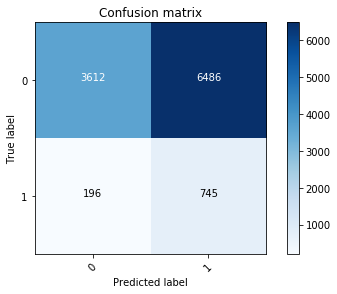

In [73]:
fpr, tpr, tresh = roc_curve(true_vz, pred_vz )
cm = confusion_matrix(true_vz, (pred_vz > tresh[tpr > 0.8][0]).astype(int) )
plot_confusion_matrix(cm,[0,1])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Index(['month_2', 'aimi_0', 'month_1', 'aimi_10', 'uvozr', 'month_4',
       'month_12', 'month_3', 'month_8', 'mesto', 'month_11', 'month_10',
       'obraz', 'weekday', 'aimi_20', 'opyt', 'month_9', 'aimi_30', 'aimi_-10',
       'aimi_-20', 'wgender', 'day', 'hour', 'month_5', 'month_7', 'stoim',
       'month_6', 'aimi_40', 'city', 'prodolzh', 'ulevel', 'aimi_-30'],
      dtype='object')
0.6580758320015051


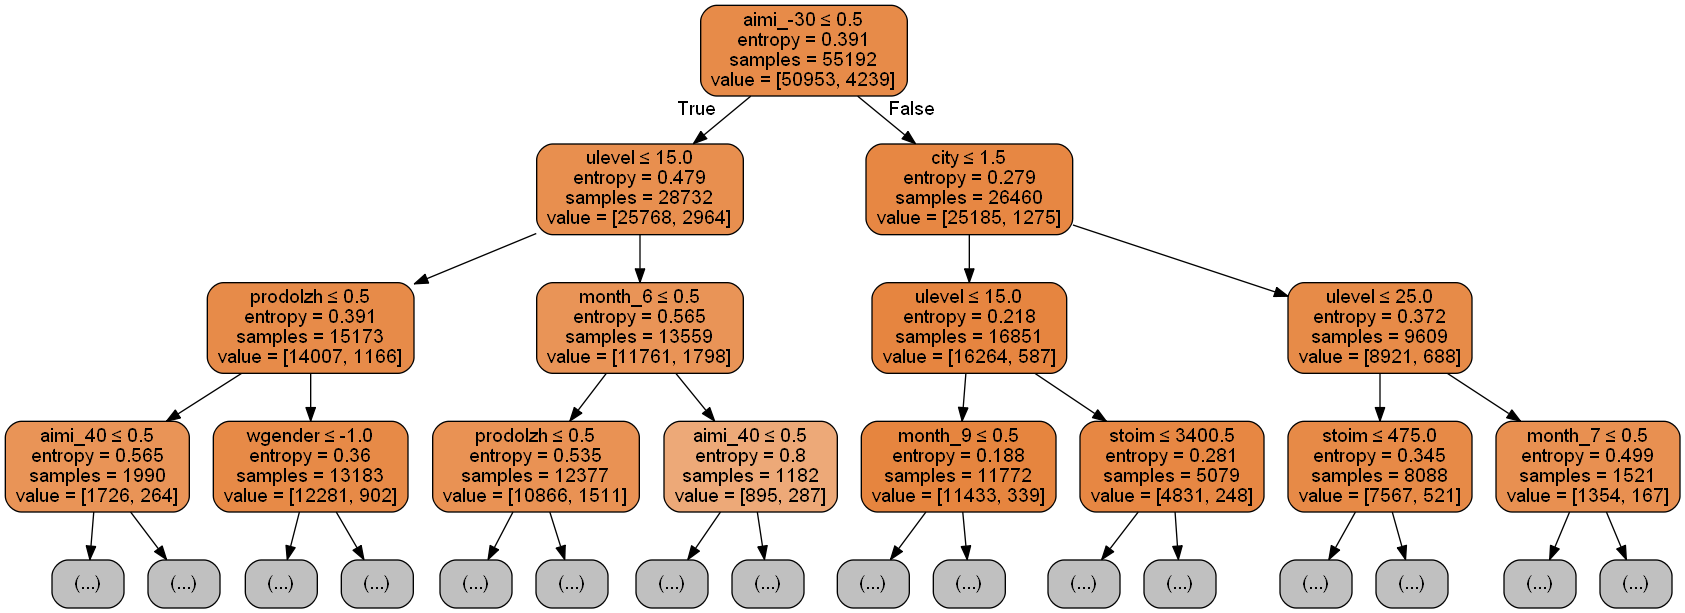

In [74]:
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

# Студенты month


In [78]:
tree_st = tree_data[tree_data['uvozr'].isin([50,60])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score,_,_ = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:05<00:00,  5.43s/it]


Text(0,0.5,'Roc_auc')

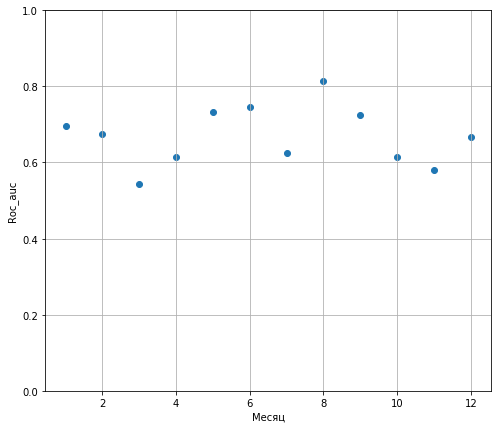

In [90]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')


# Младшие month

In [76]:
tree_st = tree_data[tree_data['uvozr'].isin([10,20,25,30])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score, _, _ = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:07<00:00,  5.63s/it]


Text(0,0.5,'Roc_auc')

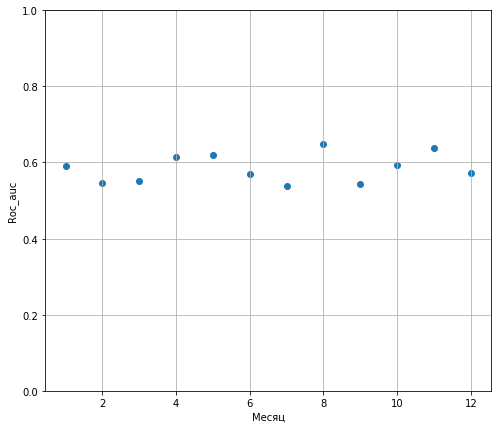

In [77]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')


# Взрослые month

In [92]:
tree_st = tree_data[tree_data['uvozr'].isin([70,80,90])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:52<00:00,  9.34s/it]


Text(0,0.5,'Roc_auc')

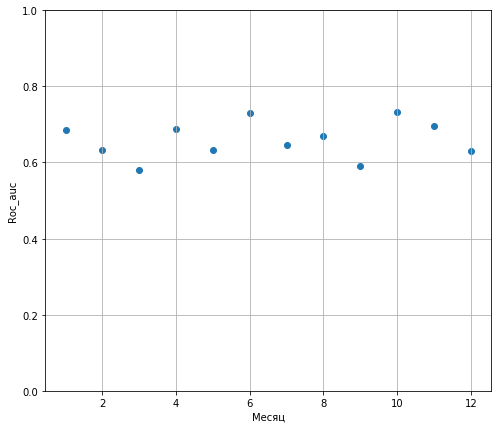

In [93]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')


# Старшие школьники month

In [94]:
tree_st = tree_data[tree_data['uvozr'].isin([35,40])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:10<00:00,  5.85s/it]


Text(0,0.5,'Roc_auc')

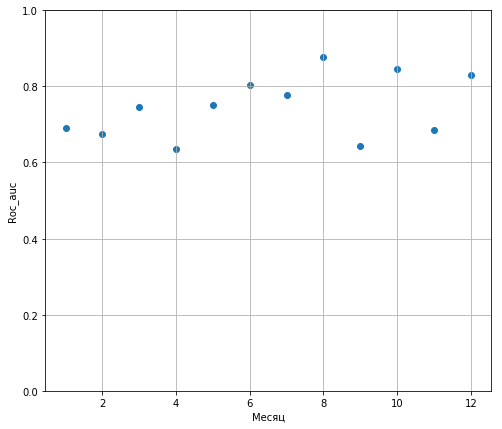

In [95]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')


In [420]:
def one_tree_gc(X, y, depth=3):
    dt = DecisionTreeClassifier()
    
    params = {'criterion': ['gini', 'entropy'],
         'max_depth': [1,2,3,4,5,6,7,8,9,10,15,25,50,100,150,200,None],
         'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    
    cv = TimeSeriesSplit(n_splits=8)
    gs = GridSearchCV(dt, params, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    gs.fit(X, y)
    
    score = gs.best_score_
    dt = gs.best_estimator_
    dt.fit(X, y)
    
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data, max_depth=depth, feature_names=X.columns,
    filled=True, rounded=True,
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png())
    return score, img
    
    

# Одно дерево старшие

# Одно дерево

In [237]:
dt = DecisionTreeClassifier()

In [238]:
params = {'criterion': ['gini', 'entropy'],
         'max_depth': [1,2,3,4,5,6,7,8,9,10,15,25,50,100,150,200,None],
         'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

In [239]:
cv = TimeSeriesSplit(n_splits=8)

In [240]:
gs = GridSearchCV(dt, params, scoring='roc_auc', cv=cv, n_jobs=-1)

In [65]:
X_tree = tree_data_no_spr.drop(columns=['target','year'])
X_tree = pd.get_dummies(X_tree, columns=['aimi'])
y_tree = tree_data_no_spr['target']

In [67]:
X_tree.head()

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,uvozr,ulevel,...,weekday,day,aimi_-30.0,aimi_-20.0,aimi_-10.0,aimi_0.0,aimi_10.0,aimi_20.0,aimi_30.0,aimi_40.0
472677,1,1.0,2.0,600.0,-2.0,20.0,55.0,2.0,30.0,20.0,...,1,1,0,0,0,0,0,0,1,0
127726,0,-1.0,1.0,1500.0,0.0,20.0,0.0,2.0,40.0,30.0,...,1,1,0,0,0,0,0,0,1,0
459735,2,0.0,0.0,1000.0,0.0,0.0,0.0,-2.0,60.0,20.0,...,1,1,0,0,0,0,0,0,1,0
291521,2,0.0,1.0,600.0,2.0,20.0,60.0,7.0,30.0,20.0,...,1,1,0,0,0,0,1,0,0,0
408108,2,1.0,2.0,350.0,0.0,20.0,55.0,12.0,70.0,10.0,...,1,1,0,0,1,0,0,0,0,0


In [241]:
gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50, 100, 150, 200, None], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [253]:
gs.best_score_

0.7872698321847916

In [242]:
dt = gs.best_estimator_
dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [244]:
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [245]:
dt.feature_importances_

array([0.00231867, 0.        , 0.00979351, 0.0092019 , 0.        ,
       0.        , 0.        , 0.56235919, 0.091035  , 0.27546545,
       0.00755151, 0.        , 0.        , 0.00072452, 0.04155025])

In [246]:
X.head()

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,aimi,uvozr,ulevel,hour,weekday,day,year
472677,1,1.0,2.0,600.0,-2.0,20.0,55.0,2.0,30.0,30.0,20.0,1,1,1,2013
127726,0,-1.0,1.0,1500.0,0.0,20.0,0.0,2.0,30.0,40.0,30.0,9,1,1,2013
459735,2,0.0,0.0,1000.0,0.0,0.0,0.0,-2.0,30.0,60.0,20.0,12,1,1,2013
291521,2,0.0,1.0,600.0,2.0,20.0,60.0,7.0,10.0,30.0,20.0,12,1,1,2013
408108,2,1.0,2.0,350.0,0.0,20.0,55.0,12.0,-10.0,70.0,10.0,13,1,1,2013


In [248]:
X.columns[np.argsort(dt.feature_importances_)]

Index(['mesto', 'wgender', 'obraz', 'opyt', 'hour', 'weekday', 'day', 'city',
       'ulevel', 'stoim', 'prodolzh', 'year', 'aimi', 'uvozr', 'razvned'],
      dtype='object')

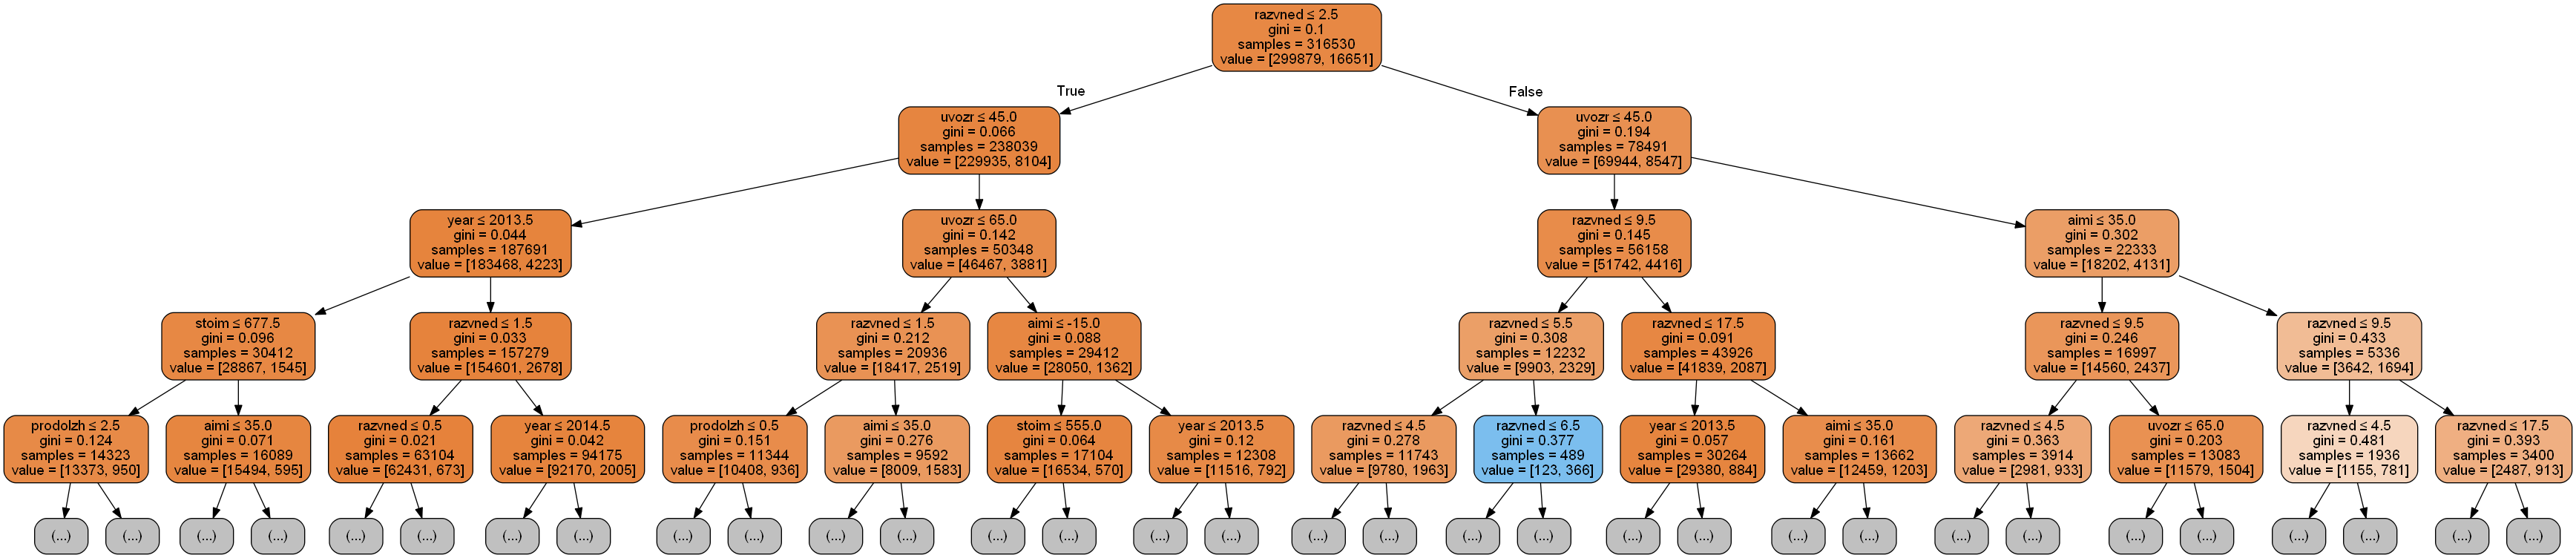

In [250]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, max_depth=4, feature_names=X.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# ---

In [51]:
dt = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'],
         'max_depth': [1,2,3,4,5,6,7,8,9,10,15,25,50,100,150,200,None],
         'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

In [52]:
cv = TimeSeriesSplit(n_splits=6)

In [53]:
gs = GridSearchCV(dt, params, scoring='roc_auc', cv=cv, n_jobs=-1)

In [56]:
X_tree = tree_data_spr.drop(columns=['target'])
y_tree = tree_data_spr['target']

In [57]:
gs.fit(X_tree, y_tree)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50, 100, 150, 200, None], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [58]:
dt = gs.best_estimator_
dt.fit(X_tree, y_tree)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [59]:
X_tree.columns[np.argsort(dt.feature_importances_)]

Index(['obraz', 'wgender', 'city', 'opyt', 'weekday', 'mesto', 'prodolzh',
       'hour', 'stoim', 'ulevel', 'uvozr', 'day', 'month', 'year', 'aimi',
       'razvned'],
      dtype='object')

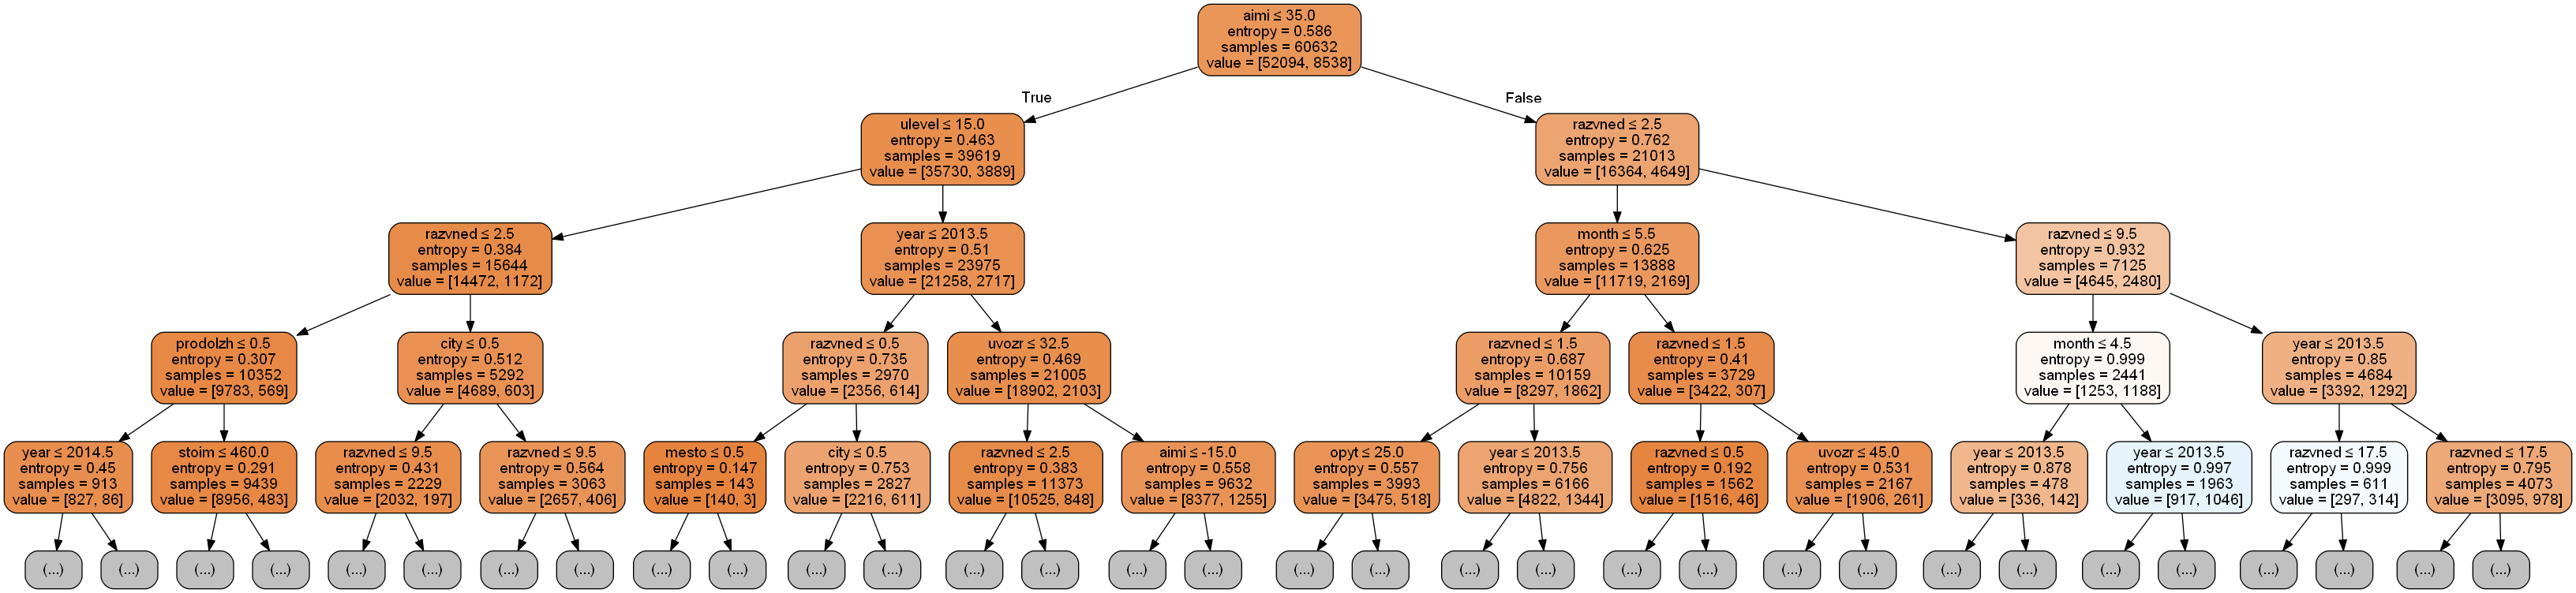

In [60]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, max_depth=4, feature_names=X_tree.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# ---

In [64]:
log_data.head()

,stoim,target,mesto_-1.0,mesto_0.0,mesto_1.0,mesto_3.0,prodolzh_-2.0,prodolzh_-1.0,prodolzh_0.0,prodolzh_1.0,...,day_28,day_29,day_30,day_31,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,-0.223325,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.213977,0.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-0.028969,0.0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,-0.223325,0.0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,-0.344797,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Лес до апреля 2017

In [259]:
tree_data.head(1)

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,aimi,uvozr,ulevel,target,month,hour,weekday,day,year
472677,1,1.0,2.0,600.0,-2.0,20.0,55.0,2.0,30.0,30.0,20.0,0.0,1,1,1,1,2013


In [261]:
tree_data_ba = tree_data[tree_data['year'] != 2018]
tree_data_ba = tree_data_ba[~((tree_data_ba['year'] == 2017) & (tree_data_ba['month'] > 3))]

In [262]:
X_ba = tree_data_ba.drop(columns=['target','year'])
y_ba = tree_data_ba['target']

In [263]:
fr = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = TimeSeriesSplit(n_splits = 8)

In [264]:
cross_val_score(fr, X_ba, y_ba, scoring ='roc_auc', cv=cv, n_jobs=-1)

array([0.78117443, 0.8383334 , 0.81499895, 0.87895433, 0.85340985,
       0.82057148, 0.844874  , 0.81365752])

In [247]:
X.head()

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,aimi,uvozr,ulevel,hour,weekday,day,year
472677,1,1.0,2.0,600.0,-2.0,20.0,55.0,2.0,30.0,30.0,20.0,1,1,1,2013
127726,0,-1.0,1.0,1500.0,0.0,20.0,0.0,2.0,30.0,40.0,30.0,9,1,1,2013
459735,2,0.0,0.0,1000.0,0.0,0.0,0.0,-2.0,30.0,60.0,20.0,12,1,1,2013
291521,2,0.0,1.0,600.0,2.0,20.0,60.0,7.0,10.0,30.0,20.0,12,1,1,2013
408108,2,1.0,2.0,350.0,0.0,20.0,55.0,12.0,-10.0,70.0,10.0,13,1,1,2013


In [152]:
cv = TimeSeriesSplit(n_splits=30)
lr = LogisticRegressionCV(Cs = [0.05],cv = cv, scoring='roc_auc', n_jobs=-1)

In [153]:
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.05], class_weight=None,
           cv=TimeSeriesSplit(max_train_size=None, n_splits=30),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

In [154]:
dates = [str(data.iloc[int(len(data) * x)]['receivd'].date()) for x in np.linspace(0.01,0.99,31)]

Text(0,0.5,'roc auc')

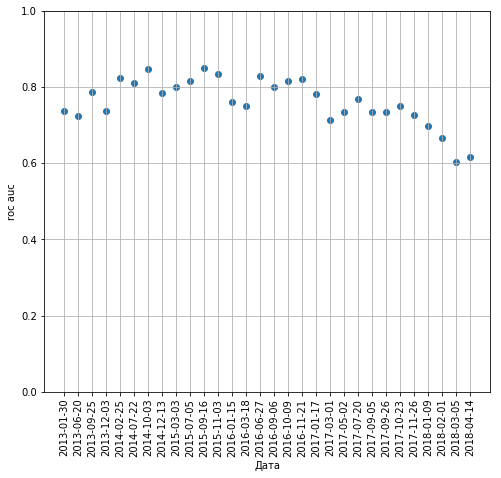

In [155]:
plt.figure(figsize=(8,7))
plt.scatter(dates[:30],lr.scores_[1])
plt.ylim(0,1)
plt.xticks(dates[:30], rotation='vertical')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('roc auc')


In [81]:
dates = [str(data.iloc[int(len(data) * x)]['receivd'].date()) for x in np.linspace(0.01,0.99,31)]

In [158]:
data_sparse.head()

,receivd,stoim,target,year,mesto_-1.0,mesto_0.0,mesto_1.0,mesto_3.0,prodolzh_-2.0,prodolzh_-1.0,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,2013-01-01 01:17:54,-0.223325,0.0,2013,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01 09:40:31,0.213977,0.0,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01 12:38:29,-0.028969,0.0,2013,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01 12:58:29,-0.223325,0.0,2013,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01 13:09:45,-0.344797,0.0,2013,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def get_splits(data, n_splits):
    idxs = np.linspace(0, len(data), n_splits+1).astype(int)
    return [data.iloc[idxs[i]:idxs[i+1]] for i, _ in enumerate(idxs[:len(idxs)-1])]

In [ ]:
splits = get_splits(data_sparse, 100)

In [223]:
lr1 = LogisticRegression(C=0.05, n_jobs=-1, solver='lbfgs')

In [17]:
def new_cv(est, splits, rng):
    scores = []
    dates = []
    for i in tqdm(range(len(splits) - rng)):
        train_X = pd.concat(splits[i:i+rng]).drop(columns=['receivd', 'target'])
        test_X = splits[i+rng].drop(columns=['receivd', 'target'])
        train_y = pd.concat(splits[i:i+rng])['target'].values
        test_y = splits[i+rng]['target'].values
        est.fit(train_X, train_y)
        scores.append(roc_auc_score(test_y, est.predict_proba(test_X)[:,1]))
        dates.append(str(splits[i+rng-1].iloc[-1]['receivd'].date()))
    print(len(train_y), len(test_y))
    return scores, dates

In [229]:
scores, dates = new_cv(fr, splits, 3)


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:53<00:00, 18.67s/it]


97595 4880


Text(0,0.5,'roc auc')

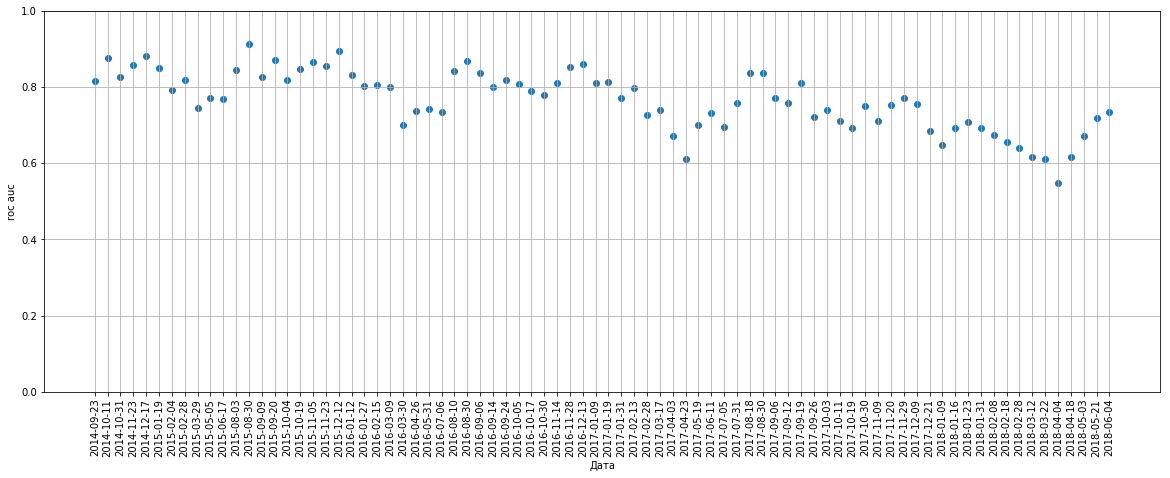

In [24]:
plt.figure(figsize=(20,7))
plt.scatter(dates,scores)
plt.ylim(0,1)
plt.xticks(dates, rotation='vertical')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('roc auc')


In [23]:
splits = get_splits(data, 100)
scores, dates = new_cv(fr, splits, 20)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [03:41<00:00,  2.77s/it]


97595 4880


In [238]:
gb = data.groupby(['year','month'])

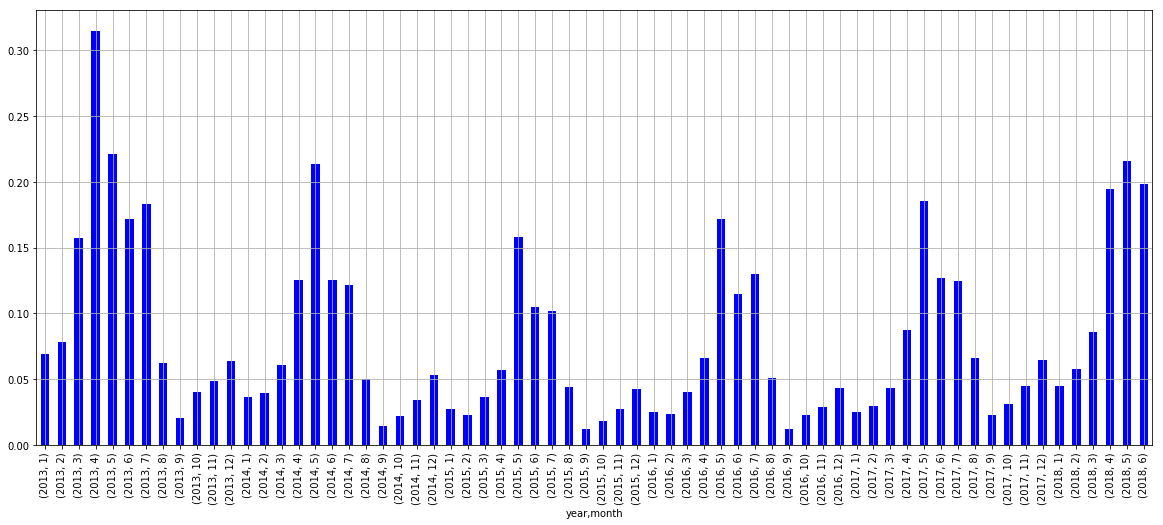

In [269]:
grp = gb['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True)

In [266]:
data.head()

,receivd,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,aimi,uvozr,ulevel,target,month,hour,weekday,day,year
472677,2013-01-01 01:17:54,1,1.0,2.0,600.0,-2.0,20.0,55.0,2.0,30.0,30.0,20.0,0.0,1,1,1,1,2013
127726,2013-01-01 09:40:31,0,-1.0,1.0,1500.0,0.0,20.0,0.0,2.0,30.0,40.0,30.0,0.0,1,9,1,1,2013
459735,2013-01-01 12:38:29,2,0.0,0.0,1000.0,0.0,0.0,0.0,-2.0,30.0,60.0,20.0,0.0,1,12,1,1,2013
291521,2013-01-01 12:58:29,2,0.0,1.0,600.0,2.0,20.0,60.0,7.0,10.0,30.0,20.0,0.0,1,12,1,1,2013
408108,2013-01-01 13:09:45,2,1.0,2.0,350.0,0.0,20.0,55.0,12.0,-10.0,70.0,10.0,0.0,1,13,1,1,2013


In [277]:
data = shuffle(data)

In [14]:
data.head()

,receivd,city,mesto,prodolzh,stoim,wgender,obraz,opyt,razvned,aimi,uvozr,ulevel,target,month,hour,weekday,day,year
472677,2013-01-01 01:17:54,1,1.0,2.0,600.0,-2.0,20.0,55.0,2.0,30.0,30.0,20.0,0.0,1,1,1,1,2013
127726,2013-01-01 09:40:31,0,-1.0,1.0,1500.0,0.0,20.0,0.0,2.0,30.0,40.0,30.0,0.0,1,9,1,1,2013
459735,2013-01-01 12:38:29,2,0.0,0.0,1000.0,0.0,0.0,0.0,-2.0,30.0,60.0,20.0,0.0,1,12,1,1,2013
291521,2013-01-01 12:58:29,2,0.0,1.0,600.0,2.0,20.0,60.0,7.0,10.0,30.0,20.0,0.0,1,12,1,1,2013
408108,2013-01-01 13:09:45,2,1.0,2.0,350.0,0.0,20.0,55.0,12.0,-10.0,70.0,10.0,0.0,1,13,1,1,2013


In [278]:
X = data.drop(columns = ['target', 'receivd']).iloc[:100000]
y = data['target'].iloc[:100000]

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2)

In [20]:
fr = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [285]:
fr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [287]:
score1 = roc_auc_score(y_test, fr.predict_proba(X_test)[:,1])
score1

0.821841726154307

In [289]:
fpr1, tpr1, tresh1 = roc_curve(y_test, fr.predict_proba(X_test)[:,1] )

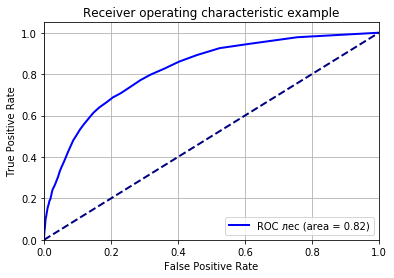

In [290]:
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='blue',
         lw=lw, label='ROC лес (area = %0.2f)' % score1)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [300]:
tresh1[tpr1>0.6]

array([0.14      , 0.1375    , 0.13      , 0.126     , 0.12      ,
       0.11333333, 0.11      , 0.1       , 0.09      , 0.08      ,
       0.07      , 0.065     , 0.06      , 0.0575    , 0.05      ,
       0.04      , 0.03      , 0.02      , 0.01      , 0.        ])

In [298]:
(fr.predict_proba(X_test)[:,1] > 0.06).astype(int)

array([0, 0, 0, ..., 0, 0, 1])

In [301]:
confusion_matrix(y_test, (fr.predict_proba(X_test)[:,1] > 0.14).astype(int))

array([[16196,  2473],
       [  553,   778]], dtype=int64)

In [306]:
Y_M = y_test[X_test['year'] == 2014]
(fr.predict_proba(X_test)[:,1] > 0.14).astype(int)[X_test['year'] == 2014]

array([0, 0, 0, ..., 0, 0, 0])

In [358]:
tnr = []
tpr = []
monthes = []
for year, month in itertools.product([2013,2014,2015,2016,2017,2018],[1,2,3,4,5,6,7,8,9,10,11,12]):
    cm = confusion_matrix(y_test[(X_test['year'] == year) & (X_test['month'] == month)], (fr.predict_proba(X_test)[:,1] > 0.14).astype(int)[(X_test['year'] == year) & (X_test['month'] == month)] )
    if cm.shape[0] != 0:
        tpr.append(cm[1][1] / np.sum(cm[1]))
        tnr.append(cm[0][0] / np.sum(cm[0]))
        monthes.append(str([month, year]))

In [354]:
itertools.product([2013,2014,2015,2016,2017,2018],[1,2,3,4,5,6,7,8,9,10,11,12])

Text(0,0.5,'tpr')

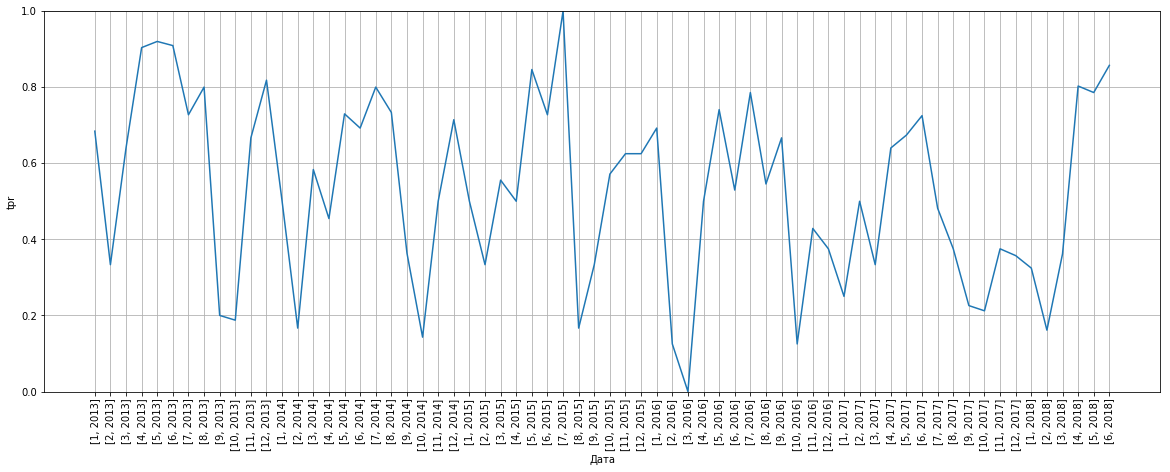

In [360]:
plt.figure(figsize=(20,7))
plt.plot(monthes, tpr)
plt.ylim(0,1)
plt.xticks(monthes, rotation='vertical')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('tpr')

Text(0,0.5,'tnr')

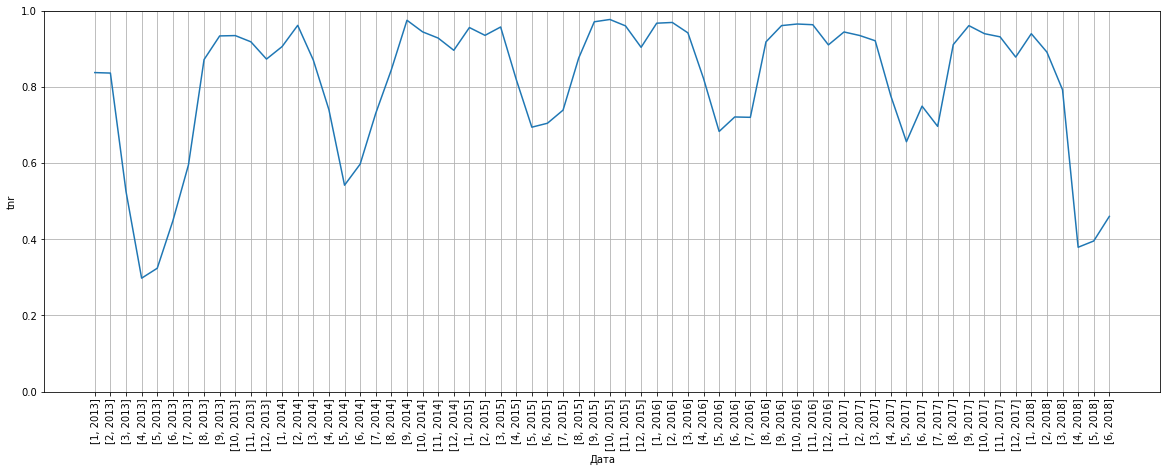

In [363]:
plt.figure(figsize=(20,7))
plt.plot(monthes, tnr)
plt.ylim(0,1)
plt.xticks(monthes, rotation='vertical')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('tnr')

In [351]:
months = list(map(lambda x: '_'.join(map(str,x)),list(itertools.product([2013,2014,2015,2016,2017,2018],[1,2,3,4,5,6,7,8,9,10,11,12]))))

In [ ]:
X